Step 1 : Scrape data

In [1]:
from bs4 import BeautifulSoup
import requests

In [2]:
article = "https://thehimalayantimes.com/sports/harry-kane-close-to-sealing-transfer-to-bayern-munich-from-tottenham"
response = requests.get(article)
content = response.content

In [3]:
parsed_text = BeautifulSoup(content, "html.parser")

In [4]:
article_text = ""
for paragraph in parsed_text.find_all('p'):
    article_text += paragraph.get_text() + " "

In [5]:
# import nltk
# from nltk.tokenize import sent_tokenize
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
# nltk.download("punkt")
# nltk.download("stopwords")
# nltk.download("wordnet")
# nltk.download('omw-1.4')
# from nltk.chunk import RegexpParser
# from nltk import pos_tag, ne_chunk
# nltk.download("maxent_ne_chunker")
# nltk.download("words")
# nltk.download("averaged_perceptron_tagger")

# grammar = r"""
#     NP: {<DT>?<JJ>*<NN.*>}
# """

# sentence = sent_tokenize(article_text)

# lemmatizer = WordNetLemmatizer()
# stop_words = set(stopwords.words("english"))
# processed_sentences = []

# for s in sentence:
#     words = nltk.word_tokenize(s)
#     words = [lemmatizer.lemmatize(word.lower()) for word in words if word.isalnum()]
#     words = [word for word in words if word not in stop_words]
#     processed_sentences.append(words)

# for i , words in enumerate(processed_sentences):
#     print(f"Sentence {i+1}: {words}")
    
# entities = []
# relationships = []

# for s in sentence:
#     words = nltk.word_tokenize(s)
#     words = [lemmatizer.lemmatize(word.lower()) for word in words if word.isalnum()]
#     words = [word for word in words if word not in stop_words]
    
#     tagged_words = pos_tag(words)
    
#     named_entities = ne_chunk(tagged_words)
    
#     chunk_parser = RegexpParser(grammar)
#     tree = chunk_parser.parse(named_entities)
    
#     for subtree in tree.subtrees():
#         if subtree.label() == "NP":
#             entity = " ".join([word for word, _ in subtree.leaves()])
#             entities.append(entity)
        
#     for chunk in tree.subtrees():
#         if chunk.label() == "NP":
#             for i in range(len(chunk)):
#                 if chunk[i][1] == "NNP":
#                     sub = " ".join([word for word, _ in chunk.leaves()])
#                     obj = " ".join([word for word, _ in chun[i + 1:].leaves()])
#                     relationships.append((sub,obj))

Step 2 & 3: Process text for sentences using spacy, extract subject, object, relationship and entity

In [6]:
import spacy
nlp = spacy.load('en_core_web_sm')
sentences = [sent.text for sent in nlp(article_text).sents]

In [7]:
all_entities = []
all_subjects = []
all_objects = []
all_relationships = []


for sentence in sentences:
    
    doc = nlp(sentence)
    
    
    sentence_entities = []
    sentence_subjects = []
    sentence_objects = []
    sentence_relationships = []
    
    
    for token in doc:
        
        if token.ent_type_ != "":
            sentence_entities.append((token.text, token.ent_type_))
        
        
        if "subj" in token.dep_:
            sentence_subjects.append(token.text)
        elif "obj" in token.dep_:
            sentence_objects.append(token.text)
        
        #relationships based on prepositions and adjectives
        if "prep" in token.dep_:
            for child in token.children:
                if "subj" in child.dep_:
                    sentence_subjects.append(child.text)
                elif "obj" in child.dep_:
                    sentence_objects.append(child.text)
            sentence_relationships.append(token.text)
        if "amod" in token.dep_:
            sentence_subjects.append(token.head.text)
            sentence_relationships.append(token.text)
    
    # duplicates delete
    sentence_entities = list(set(sentence_entities))
    sentence_subjects = list(set(sentence_subjects))
    sentence_objects = list(set(sentence_objects))
    sentence_relationships = list(set(sentence_relationships))
    
    
    all_entities.append(sentence_entities)
    all_subjects.append(sentence_subjects)
    all_objects.append(sentence_objects)
    all_relationships.append(sentence_relationships)

#
# for i, sentence in enumerate(sentences):
#     print(f"Sentence {i + 1}:")
#     print("Entities:", all_entities[i])
#     print("Subjects:", all_subjects[i])
#     print("Objects:", all_objects[i])
#     print("Relationships:", all_relationships[i])
#     print("\n")

step 4 : Building a directed graph from the above data with entities as a node and relationships as
an edge

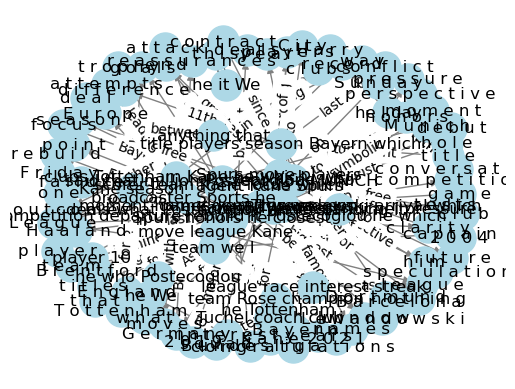

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.DiGraph()


for i in range(len(all_subjects)):
    for j in range(len(all_relationships[i])):
        if j < len(all_objects[i]):
            source = ' '.join(all_subjects[i])
            target = ' '.join(all_objects[i][j])  
            relation = all_relationships[i][j]

            G.add_node(source, label=' '.join(all_subjects[i]), type='entity')
            G.add_node(target, label=' '.join(all_objects[i][j]), type='entity') 
            G.add_edge(source, target, label=relation)

# Visualizing graph
pos = nx.spring_layout(G, seed=42)  
node_labels = nx.get_node_attributes(G, 'label')
edge_labels = nx.get_edge_attributes(G, 'label')

nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')
nx.draw_networkx_labels(G, pos, labels=node_labels)
nx.draw_networkx_edges(G, pos, edge_color='gray')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.axis('off')
plt.show()

In [9]:
print("Nodes:", G.nodes())
print("Edges:", G.edges(data=True))

Nodes: ['said that million Postecoglou MUNICH', 'M u n i c h', 'T o t t e n h a m', 'd e a l', 'move league Kane', 't r o p h y', 'l e a g u e', 't i t l e s', 'E u r o p e', 'B a y e r n', 'y e a r s', 'deals what Postecoglou understanding it', 'd e a l s', 'p o i n t', 'B u n d e s l i g a', 'w i n d o w', 'Kane Bayern tests', 'd e b u t', 'G e r m a n y', 't e s t s', 'F r i d a y', 'broadcaster Sports he', 'r e a s s u r a n c e s', 'Tuchel coach club', 'K a n e', 'priority We focus Tuchel pressure', 'p r e s s u r e', 'team we I', 't e a m', 'L e a g u e', 'E n g l a n d', 'c a p t a i n', 'scorer team Kane focus which', 'g o a l s', 'a t t a c k', 'B a r c e l o n a', 'f o c u s', 'r e c o r d', 'L e w a n d o w s k i', 'game departure season', 'h o l e', 's q u a d', 'B r e n t f o r d', 'S u n d a y', 'g a m e', 's e a s o n', 'competition departure rebuild It Postecoglou he which', 'c o m p e t i t i o n', 'c l a r i t y', 't h a t', 'r e b u i l d', 'f a i l u r e', 'he it We

step 5 : Save the graph db

In [10]:
nx.write_graphml(G, 'graph.graphml')

step 6 : answer the question extracted from graph

In [11]:
G = nx.read_graphml('graph.graphml')

question = "kane league move to which league?"


target_node = None
for edge in G.edges(data=True):
    source_node, target_node, edge_data = edge
    if source_node.lower() == "kane league move" and edge_data['label'].lower() == "to":
        target_node = target_node
        break

if target_node:
    print("Answer:", target_node)
else:
    print("Answer not found for the question:", question)

Answer: B u n d e s l i g a
